In [1]:
import cv2 as cv
import sys
import numpy as np
import os.path
import os 
import time
import matplotlib.pyplot as plt
import statistics

In [2]:
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [3]:
def get_class_names(fname):
    classesFile = f'/content/drive/My Drive/darknet/{fname}'
    with open(classesFile,mode='r+') as file:
      classes = file.readlines()
    class_names = [c.strip() for c in classes]
    return class_names

In [4]:
def net_define(model_cfg,model_wgts):
  modelConfiguration = f'/content/drive/MyDrive/darknet/cfg/{model_cfg}'
  modelWeights       = f'/content/drive/MyDrive/darknet/backup/{model_wgts}'
  net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
  net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
  net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
  return modelConfiguration,modelWeights,net

In [103]:
# Initialize the parameters
confThreshold = 0.15  #Confidence threshold
nmsThreshold = 0.5  #Non-maximum suppression threshold

inpWidth = 608       
#416 #Width of network's input image
inpHeight = 608      
#416 #Height of network's input image

# Give the configuration and weight files for the model and load the network using them.
classes = get_class_names('obj.names')
modelConfiguration,modelWeights,net = net_define('yolov3.cfg','yolov3_last.weights')

image_path = '/content/drive/MyDrive/darknet/img/Test_Images'
#video_path = '/content/drive/MyDrive/testvideo.mp4'


In [104]:
def helmet_color_boxes_avg(left,top,right,bottom,img):
  r_list =[]
  g_list =[]
  b_list =[]
  for x_coord in range(img.shape[0]):
    for y_coord in range(img.shape[1]):
     r_list.append(img[x_coord][y_coord][0])
     g_list.append(img[x_coord][y_coord][1])
     b_list.append(img[x_coord][y_coord][2])
  r_mean = int(statistics.mode(r_list))
  b_mean = int(statistics.mode(b_list))
  g_mean = int(statistics.mode(g_list))
  
  cv.rectangle(img, (left, top), (right, bottom),(r_mean,g_mean,b_mean), 3 )
  return b_mean,g_mean,r_mean

In [55]:
def helmet_color_boxes(left,top,right,bottom,img):
  x_mid = int((left+top)/2)
  y_mid = int((right+bottom)/2)
  b,g,r = img[x_mid][y_mid]
  cv.rectangle(img, (left, top), (right, bottom),(int(r),int(g),int(b)), 3)
  return int(b),int(g),int(r)

In [105]:
def drawPred(classId, conf, left, top, right, bottom, framecount,frame,path,color=False):
    # Draw a bounding box.
    #    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    if framecount % 10 == 0:
      timestamp = str(time.time())[6:10] + str(time.time())[11:14]
      cropped_frame = frame[top:bottom,left:right]
      try:
        cv.imwrite(os.path.join(path , '{:06d}'.format(framecount) + '_' + timestamp + '.jpg'), cropped_frame)
      except:
        print(f'Frame {framecount} skipped')
    if color:
      b,g,r, = helmet_color_boxes_avg(left,top,right,bottom,frame)
    else:
      cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)
    label = '%.2f' % conf
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    if color:
      cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (r,g,b), cv.FILLED)
    else:
       cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0,0,255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [106]:
def postprocess(frame, outs, framecount):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    detection_count = 0
    for out in outs:
        # print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4]>confThreshold:
                detection_count += 1

            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height, framecount,frame,color=True,path = '/content/drive/MyDrive/imgs/')

In [107]:
def predict_image(image):
  sample_img = cv.imread(f'/content/drive/MyDrive/darknet/img/Test_Images/{image}')
  rgb_image = cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)
  blob = cv.dnn.blobFromImage(sample_img,1/255,(inpHeight,inpWidth),[0,0,0],swapRB=1,crop=False)
  net.setInput(blob)
  outs = net.forward(getOutputsNames(net))
  postprocess(rgb_image,outs,1)
  plt.imshow(rgb_image)

In [59]:
listimg = os.listdir('/content/drive/MyDrive/darknet/img/Test_Images')

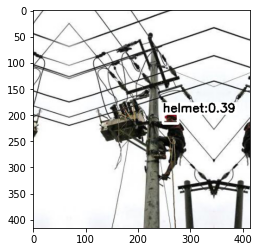

In [115]:
predict_image(listimg[36])

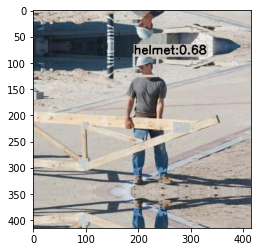

In [94]:
  sample_img = cv.imread('/content/drive/MyDrive/darknet/img/images/hard_hat_workers180.png')
  rgb_image = cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)
  blob = cv.dnn.blobFromImage(sample_img,1/255,(inpHeight,inpWidth),[0,0,0],swapRB=1,crop=False)
  net.setInput(blob)
  outs = net.forward(getOutputsNames(net))
  postprocess(rgb_image,outs,1)
  plt.imshow(rgb_image)